In [6]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 8)

## Load the Trained Model

In [7]:
BASE_DIR = Path.cwd()
model_path = BASE_DIR / "toxicity_model.pkl"

# Load the model
with open(model_path, "rb") as f:
    save_data = pickle.load(f)

if isinstance(save_data, tuple):
    model, vectorizer = save_data
    category_models = {}
    toxicity_categories = []
else:
    model = save_data.get("model")
    vectorizer = save_data.get("vectorizer")
    category_models = save_data.get("category_models", {})
    toxicity_categories = save_data.get("toxicity_categories", [])

print("Model loaded successfully")
print(f"Category models available: {list(category_models.keys())}")

Model loaded successfully
Category models available: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


/home/sulav/Code/sochnepal/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/sulav/Code/sochnepal/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/sulav/Code/sochnepal/.venv/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from ver

## Load Test Dataset

In [8]:
# Load dataset from data folder
csv_path = BASE_DIR / "data" / "train.csv"

print(f"Loading dataset from: {csv_path}")
df = pd.read_csv(csv_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
display(df.head())

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Check class distribution
toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
if all(col in df.columns for col in toxicity_columns):
    print(f"\nToxicity category distribution:")
    for col in toxicity_columns:
        toxic_count = df[col].sum()
        print(f"  {col}: {toxic_count} ({toxic_count/len(df)*100:.2f}%)")


Loading dataset from: /home/sulav/Code/sochnepal/ai-service/data/train.csv
Dataset shape: (159571, 8)

Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

First few rows:
Dataset shape: (159571, 8)

Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

First few rows:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0



Missing values:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Toxicity category distribution:
  toxic: 15294 (9.58%)
  severe_toxic: 1595 (1.00%)
  obscene: 8449 (5.29%)
  threat: 478 (0.30%)
  insult: 7877 (4.94%)
  identity_hate: 1405 (0.88%)


## Prepare Test Data

In [9]:
import re

def preprocess_text(text):
    """Clean text (same as in ToxicityDetector)"""
    text = str(text).lower().strip()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text

# Prepare test data
toxicity_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
has_toxicity_labels = all(col in df.columns for col in toxicity_columns)

# Get texts and labels
texts = df['comment_text'].values
if has_toxicity_labels:
    binary_labels = (df[toxicity_columns].sum(axis=1) > 0).astype(int).values
else:
    binary_labels = df['toxic'].values

# Filter out NaN values
mask = pd.notna(texts)
texts = texts[mask]
binary_labels = binary_labels[mask]

# Preprocess
texts_processed = [preprocess_text(text) for text in texts]

# Use a subset for testing (last 20% as test set)
test_size = int(len(texts_processed) * 0.2)
X_test = texts_processed[-test_size:]
y_test = binary_labels[-test_size:]

print(f"Test set size: {len(X_test)}")
print(f"Positive samples: {sum(y_test)} ({sum(y_test)/len(y_test)*100:.1f}%)")
print(f"Negative samples: {len(y_test)-sum(y_test)} ({(len(y_test)-sum(y_test))/len(y_test)*100:.1f}%)")

Test set size: 31914
Positive samples: 3225 (10.1%)
Negative samples: 28689 (89.9%)


## Generate Predictions

In [10]:
# Vectorize test data
X_test_vec = vectorizer.transform(X_test)

# Get predictions and probabilities
y_pred = model.predict(X_test_vec)
y_pred_proba = model.predict_proba(X_test_vec)[:, 1]

print("Predictions generated successfully")
print(f"Predicted positive samples: {sum(y_pred)} ({sum(y_pred)/len(y_pred)*100:.1f}%)")

Predictions generated successfully
Predicted positive samples: 1751 (5.5%)


## Confusion Matrix - General Toxicity Model

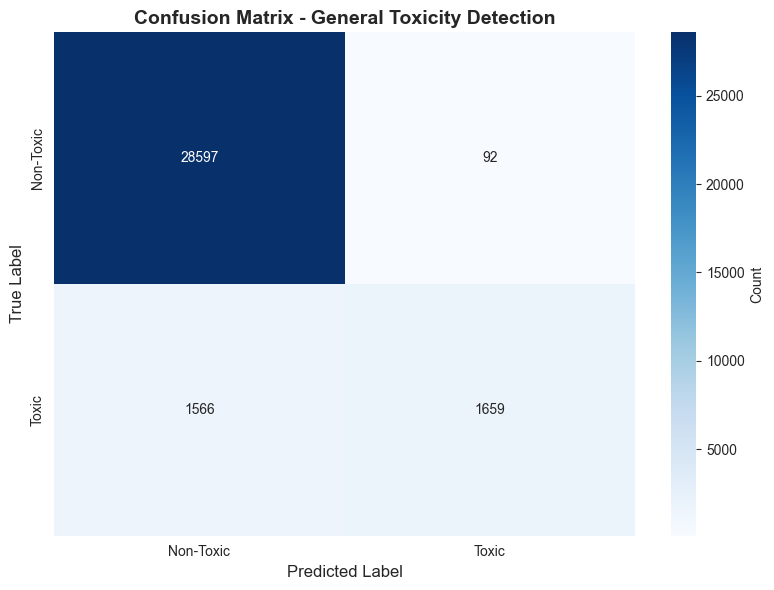


Confusion Matrix Breakdown:
True Negatives (TN): 28597
False Positives (FP): 92
False Negatives (FN): 1566
True Positives (TP): 1659


In [11]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Toxic', 'Toxic'],
            yticklabels=['Non-Toxic', 'Toxic'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - General Toxicity Detection', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

## Classification Metrics

In [12]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Classification Metrics:")
print("="*50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("="*50)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Toxic', 'Toxic']))

Classification Metrics:
Accuracy:  0.9480
Precision: 0.9475
Recall:    0.5144
F1 Score:  0.6668

Detailed Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.95      1.00      0.97     28689
       Toxic       0.95      0.51      0.67      3225

    accuracy                           0.95     31914
   macro avg       0.95      0.76      0.82     31914
weighted avg       0.95      0.95      0.94     31914



## ROC Curve and AUC

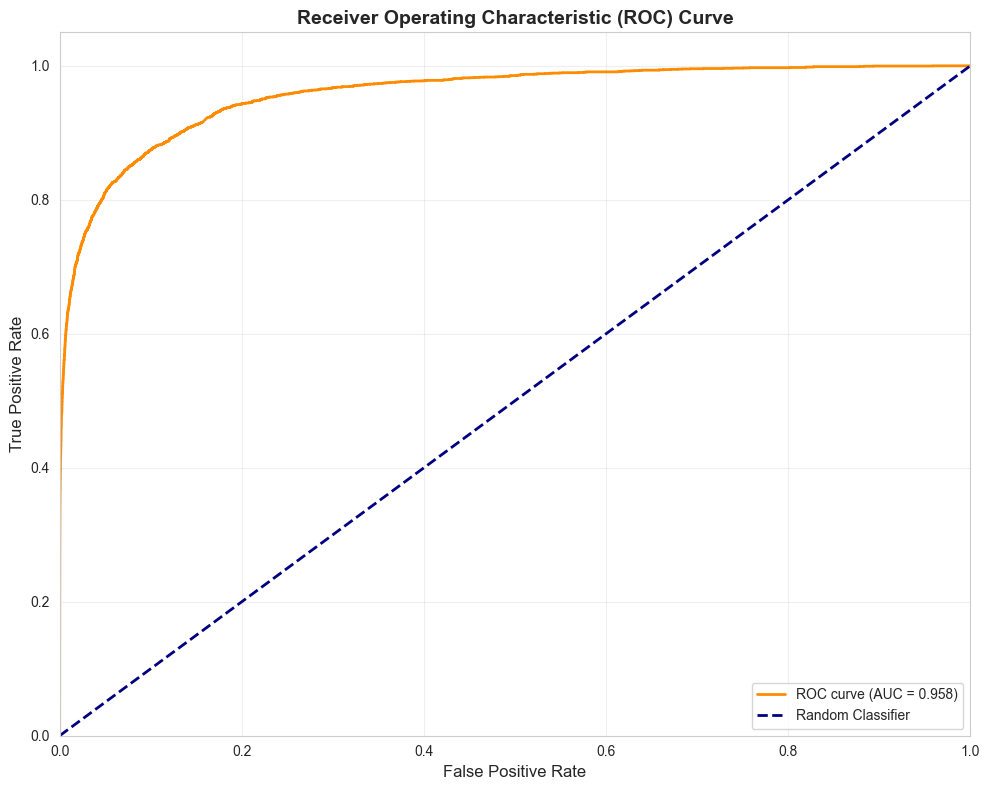


AUC Score: 0.9577


In [13]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC Score: {roc_auc:.4f}")

## Category-Specific Confusion Matrices

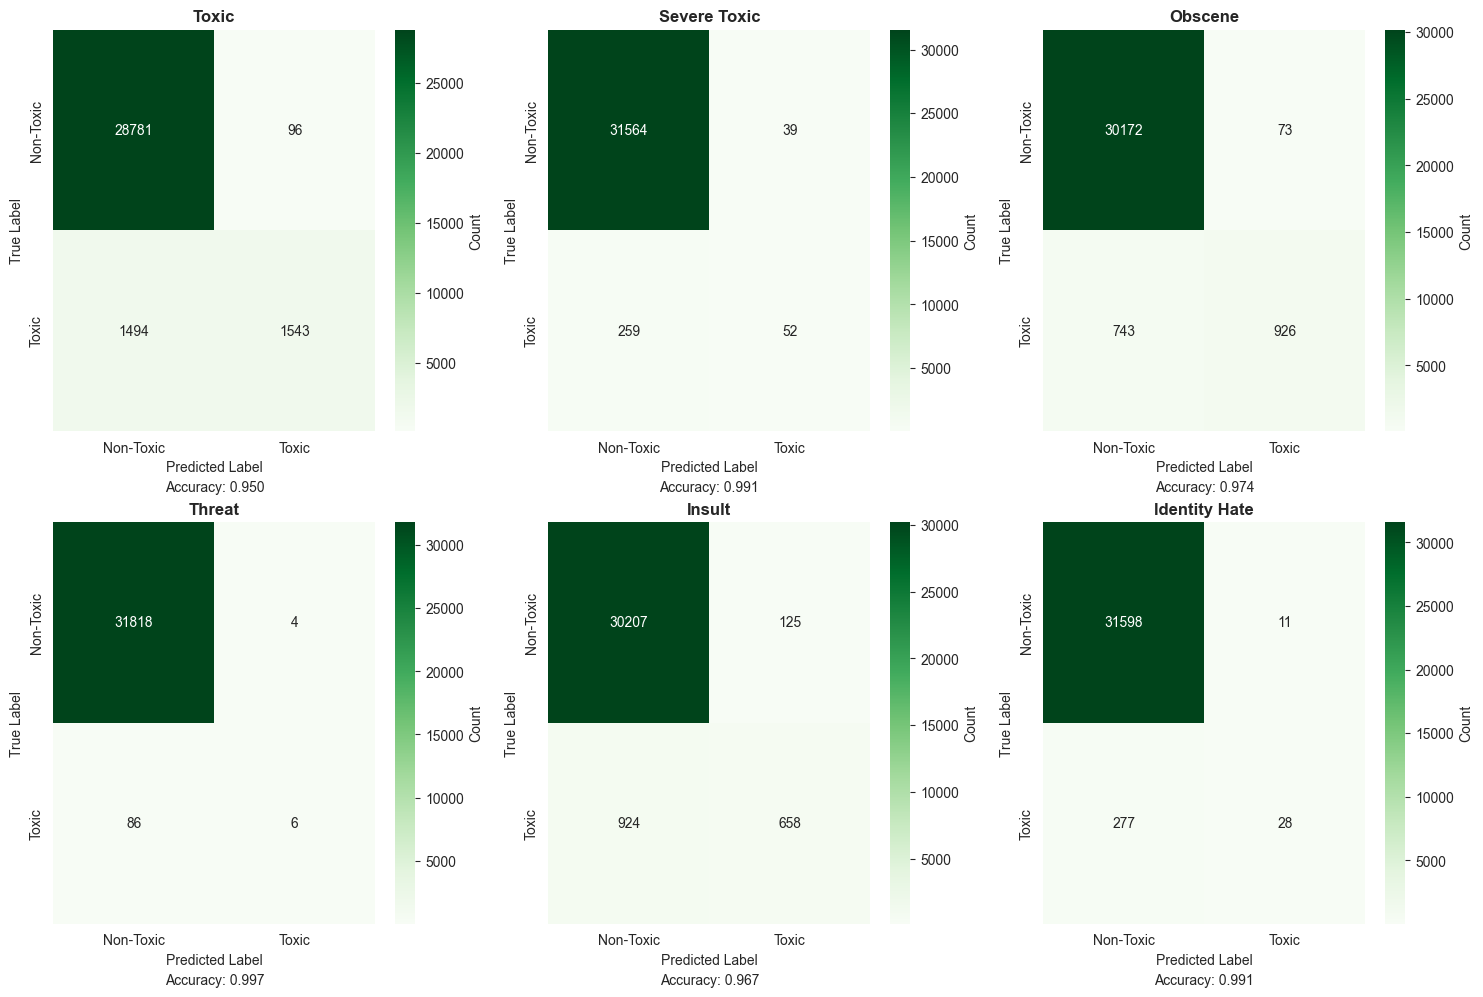

In [14]:
if category_models and has_toxicity_labels:
    # Prepare category labels
    category_labels = df[toxicity_columns].values[-test_size:]
    
    # Create subplots for each category
    n_categories = len(category_models)
    n_cols = 3
    n_rows = (n_categories + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_categories > 1 else [axes]
    
    for idx, (category, cat_model) in enumerate(category_models.items()):
        # Get category-specific labels
        cat_idx = toxicity_columns.index(category)
        y_cat_test = category_labels[:, cat_idx]
        
        # Predict
        y_cat_pred = cat_model.predict(X_test_vec)
        
        # Confusion matrix
        cm_cat = confusion_matrix(y_cat_test, y_cat_pred)
        
        # Plot
        sns.heatmap(cm_cat, annot=True, fmt='d', cmap='Greens', ax=axes[idx],
                    xticklabels=['Non-Toxic', 'Toxic'],
                    yticklabels=['Non-Toxic', 'Toxic'],
                    cbar_kws={'label': 'Count'})
        axes[idx].set_title(f'{category.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
        
        # Calculate accuracy
        cat_accuracy = accuracy_score(y_cat_test, y_cat_pred)
        axes[idx].text(0.5, -0.15, f'Accuracy: {cat_accuracy:.3f}', 
                      ha='center', transform=axes[idx].transAxes, fontsize=10)
    
    # Hide extra subplots
    for idx in range(len(category_models), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No category-specific models available.")

## Performance Metrics Summary


MODEL PERFORMANCE SUMMARY


,Metric,Score
0,Accuracy,0.9480
1,Precision,0.9475
2,Recall,0.5144
3,F1-Score,0.6668
4,AUC-ROC,0.9577


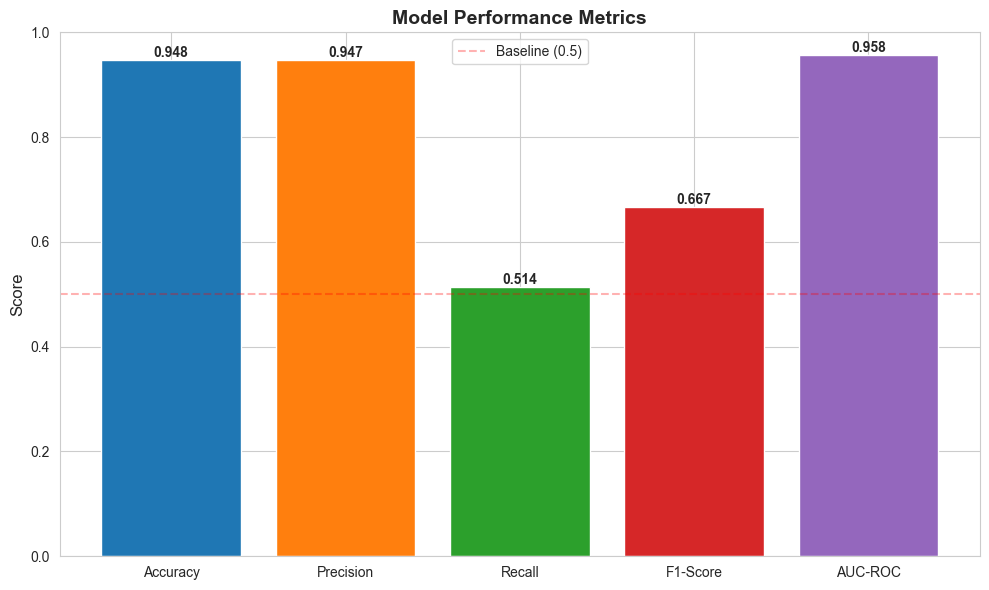

In [15]:
# Create a summary table
metrics_summary = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
    'Score': [accuracy, precision, recall, f1, roc_auc]
}

summary_df = pd.DataFrame(metrics_summary)
summary_df['Score'] = summary_df['Score'].apply(lambda x: f"{x:.4f}")

print("\n" + "="*50)
print("MODEL PERFORMANCE SUMMARY")
print("="*50)
display(summary_df)

# Visualize metrics
metrics_values = [accuracy, precision, recall, f1, roc_auc]
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1.0])
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label='Baseline (0.5)')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()

## Test Custom Examples

In [16]:
# Test with custom examples
test_examples = [
    "This is a great post, very informative!",
    "You are so stupid and dumb",
    "I hate this fucking website",
    "Thank you for sharing this information",
    "Go kill yourself you worthless piece of shit",
    "I really appreciate your help with this",
]

print("\nTesting Custom Examples:")
print("="*70)

for text in test_examples:
    processed = preprocess_text(text)
    text_vec = vectorizer.transform([processed])
    pred = model.predict(text_vec)[0]
    prob = model.predict_proba(text_vec)[0][1]
    
    label = "TOXIC" if pred == 1 else "CLEAN"
    color = "🔴" if pred == 1 else "🟢"
    
    print(f"{color} [{label}] (conf: {prob:.3f}) | {text}")
    print("-"*70)


Testing Custom Examples:
🟢 [CLEAN] (conf: 0.043) | This is a great post, very informative!
----------------------------------------------------------------------
🔴 [TOXIC] (conf: 0.999) | You are so stupid and dumb
----------------------------------------------------------------------
🔴 [TOXIC] (conf: 0.996) | I hate this fucking website
----------------------------------------------------------------------
🟢 [CLEAN] (conf: 0.020) | Thank you for sharing this information
----------------------------------------------------------------------
🔴 [TOXIC] (conf: 0.986) | Go kill yourself you worthless piece of shit
----------------------------------------------------------------------
🟢 [CLEAN] (conf: 0.032) | I really appreciate your help with this
----------------------------------------------------------------------


## Save Evaluation Results

In [17]:
# Save evaluation results to file
results = {
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'auc_roc': float(roc_auc),
    'confusion_matrix': cm.tolist(),
    'test_size': len(X_test)
}

import json
results_path = BASE_DIR / 'toxicity_evaluation_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nEvaluation results saved to: {results_path}")


Evaluation results saved to: /home/sulav/Code/sochnepal/ai-service/toxicity_evaluation_results.json
